<a href="https://colab.research.google.com/github/ikiskin/UNIQ-deepmind/blob/master/colab/UNIQ_scikit_learn_pt_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![HumBug](https://raw.githubusercontent.com/ikiskin/UNIQ-deepmind/master/data/pics/humbug-logo.png)

# **Introducing Scikit-Learn (ii): Real-world data science**

(c) by [Ivan Kiskin](https://www.surrey.ac.uk/people/ivan-kiskin), Lecturer in AI at the People-Centred AI Institute, Centre for Vision, Speech and Signal Processing (CVSSP), Surrey Sleep Research Centre (SSRC), University of Surrey.


In [1]:
# Import a few basic required libraries here:
import numpy as np  # Numpy, basic scientific and numerical computing
import matplotlib.pyplot as plt  # Python plotting
from IPython.display import Audio  # Audio playback in colab
import librosa # Library for audio reading, feature creation etc.

In this example we will give you the opportunity to explore a real-world application of `scikit-learn` to a data science problem yourself. There is no expectation on any particular scores your models might achieve, the only goal is that you get a feel for how one might approach an ML problem, and what tools exist to simplify the process.

Machine learning is prevelant in today's scientific landscape, with applications spanning Biomedical engineering, astrostatistics, finance, the entertainment industry, and countless other disciplines. 

In this tutorial we will consider how one might use ML to classify acoustics into categories. This type of analysis involves:



1.   Data collection and pre-processing
2.   Feature generation
3.   Model selection
4.   Model training
5.   Analysing model performance

You will find in practice that the key to unlocking good predictive insights is the quality and quantity of data used. We will however not make this the focal point, and assume the data is "clean" within reason. By "clean", we mean that the test and train data are generated from similar statistical distributions, there is little labelling error, etc.


## **Problem definition**
### Mosquito acoustic detection: can we use machine learning to detect mosquitoes from the sound of their acoustic wingbeat?
This work is part of the [HumBug project](https://humbug.ox.ac.uk/), which aims to combat the spread of malaria through data-driven approaches.

In 2019, for example, malaria caused around 229 million cases of disease across more than 100 countries resulting in an estimated 409,000 deaths
[World Health Organization, 2020](https://www.who.int/publications/i/item/9789240015791). Mosquito surveys are used to establish vector species’ composition and abundance, human biting rates and thus the potential to transmit a pathogen. Traditional survey methods, such as human landing catches, which collect mosquitoes as they land on the exposed skin of a collector, can be
time consuming, expensive, and are limited in the number of sites they can survey. Consequently, an affordable automated survey method that detects, identifies and counts mosquitoes could generate unprecedented levels of high-quality occurrence and abundance data over spatial and temporal scales currently difficult to achieve. The data is essential for informing policy and intervention schemes to combat malaria.

As a byproduct of their behavioural patterns, mosquitoes produce a characteristic buzz from their flight and even mating calls. The idea is to leverage this sound with cheap sensors (acoustic smartphone sensors in an IoT network) to be able to estimate the prevelance of mosquitoes in a particular area. To do this, we need algorithms capable of distinguishing the buzz of mosquito from its surroundings. In this challenge we will show how it is possible to use `scikit-learn` to build a basic classifier to achieve mosquito detection on a specific dataset collected for studying mosquito behaviour.

## 1. Data input processing 

By default, opening colab will place you in the following directory (see output from cell below). You can view the folder structure on the left-hand side by clicking on the folder in the side pane.

In [2]:
import os
os.getcwd()

'/content'

We can now donwload the dataset of interest from the repository with `wget` and unzip to the subfolder `data`. The `!` before the command is used to run operating system commands directly in the notebook cell (in this case, whichever Linux OS the colab machines are using).

In [3]:
!wget https://github.com/ikiskin/UNIQ-deepmind/raw/master/data/CulexMozzSounds.zip # Get audio files
!unzip /content/CulexMozzSounds.zip -d /content/data/ # unzip files to data subdir

!wget https://github.com/ikiskin/UNIQ-deepmind/raw/master/data/CulexUNIQ.csv -O data/CulexUNIQ.csv # Get labels and place in data subdir


--2022-07-07 08:43:02--  https://github.com/ikiskin/UNIQ-deepmind/raw/master/data/CulexMozzSounds.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ikiskin/UNIQ-deepmind/master/data/CulexMozzSounds.zip [following]
--2022-07-07 08:43:02--  https://raw.githubusercontent.com/ikiskin/UNIQ-deepmind/master/data/CulexMozzSounds.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28644396 (27M) [application/zip]
Saving to: ‘CulexMozzSounds.zip’

CulexMozzSounds.zip 100%[===================>]  27.32M   145MB/s    in 0.2s    

2022-07-07 08:43:03 (145 MB/s) - ‘CulexMozzSounds.zip’ saved [28644396/286443

To start, let us load the dataset in `pandas`, a package which makes data manipulation simpler, e.g. operations to remove columns, index by value, etc. You will find `pandas` is a very popular and commonly used package in the data science sphere, so it might be worth exploring in your own time if you are interested to learn about its functionality further.

In [4]:
import pandas as pd
df = pd.read_csv('data/CulexUNIQ.csv')
df.tail()  # Display a few label from 'tail' of dataframe entries

,id,fine_start_time,fine_end_time,path,name,sample_rate,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type
152,222690,20.0,24.832,/Culex/sounds/0056_norm.wav,0056_norm.wav,8000,background,NaN,NaN,NaN,NaN,NaN,NaN,phone,Alcatel,UK,Oxfordshire,NaN,Oxford Zoology,culture
153,222689,0.0,19.900,/Culex/sounds/0056_norm.wav,0056_norm.wav,8000,mosquito,culex quinquefasciatus,NaN,NaN,NaN,NaN,NaN,phone,Alcatel,UK,Oxfordshire,NaN,Oxford Zoology,culture
154,222657,1.9,39.680,/Culex/sounds/0057_norm.wav,0057_norm.wav,8000,background,NaN,NaN,NaN,NaN,NaN,NaN,phone,Alcatel,UK,Oxfordshire,NaN,Oxford Zoology,culture
155,222656,0.0,0.500,/Culex/sounds/0057_norm.wav,0057_norm.wav,8000,background,NaN,NaN,NaN,NaN,NaN,NaN,phone,Alcatel,UK,Oxfordshire,NaN,Oxford Zoology,culture
156,199945,0.5,1.900,/Culex/sounds/0057_norm.wav,0057_norm.wav,8000,mosquito,culex quinquefasciatus,NaN,NaN,NaN,NaN,NaN,phone,Alcatel,UK,Oxfordshire,NaN,Oxford Zoology,culture


Here we see there are extra fields related to the data, which we may use for meta-analysis. In this particular task, we are only interested in the labels. We can check which type of labels are present by examining the unique values in `sound_type`:

In [ ]:
pd.unique(df.sound_type)

array(['background', 'mosquito'], dtype=object)

These two strings will be used to create two classes, `'background'` corresponding to class 0, and `'mosquito'` to class 1.

## 2. Dataset creation
### Example file

In [ ]:
# Library to load example file
filename = '0036_norm.wav'

signal, rate = librosa.load(os.path.join('data', filename), sr=None)

df_match = df[df.name == filename]  # Index the dataframe rows matching to the filename
df_match

,id,fine_start_time,fine_end_time,path,name,sample_rate,sound_type,species,gender,fed,plurality,age,method,mic_type,device_type,country,district,province,place,location_type
113,222671,20.7,27.800,/Culex/sounds/0036_norm.wav,0036_norm.wav,8000,background,NaN,NaN,NaN,NaN,NaN,NaN,phone,Alcatel,UK,Oxfordshire,NaN,Oxford Zoology,culture
114,199929,0.0,20.700,/Culex/sounds/0036_norm.wav,0036_norm.wav,8000,mosquito,culex quinquefasciatus,NaN,NaN,NaN,NaN,NaN,phone,Alcatel,UK,Oxfordshire,NaN,Oxford Zoology,culture
115,199930,27.8,54.272,/Culex/sounds/0036_norm.wav,0036_norm.wav,8000,mosquito,culex quinquefasciatus,NaN,NaN,NaN,NaN,NaN,phone,Alcatel,UK,Oxfordshire,NaN,Oxford Zoology,culture


By executing the cell below, we will visualise an example recording, `0036_norm.wav`, its corresponding labels, and include an interactive `iPython` audio element to listen to the audio file.

Note that recordings are labelled as positive (class 1) between `fine_start_time` and `fine_end_time` where `sound_type` is `mosquito`, and negative (class 0) where `sound_type` is `background`.

The visual data representation we use is a [Spectrogram](https://en.wikipedia.org/wiki/Spectrogram), which is a plot of frequency versus time. The frequency is determined through repeated Fourier transforms in short windows, creating a heatmap of frequencies through time (called the [Short-time Fourier transform](https://en.wikipedia.org/wiki/Short-time_Fourier_transform)). Note that this is just one way we can create a visual representation, but it is often a useful starting point. More advanced deep learning solutions often use this representation as a starting point to treat the audio recognition as a computer vision problem. 

You may see for yourself which parts of the data visualisation look like the presence of a mosquito, and how that relates to the audio recording.


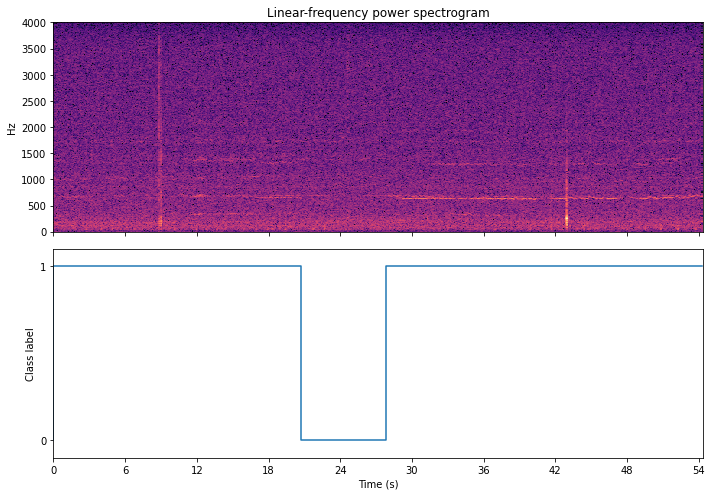

In [ ]:
import librosa.display

start_times = sorted(list(df_match.fine_start_time))
end_times = sorted(list(df_match.fine_end_time))

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,7))
D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=rate, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram')
ax[0].label_outer()

ax[1].step(np.hstack([start_times, end_times[-1]]),[0, 1, 0, 1])  # Plot corresponding labels from dataframe
ax[1].set_ylabel('Class label')
ax[1].set_yticks([0, 1])
ax[1].set_ylim([-0.1, 1.1])
ax[1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

# Create interactive audio element
Audio(data=signal, rate=rate)

### Train/test split

In machine learning, it is common to split available data into three partitions: `train`, `validation`, and `test`. Of these, algorithms must only have access to `train` and `validation` when creating models, and care needs to be taken to avoid underlying factors of the data to become discrimnating factors. 

In an ideal scenario, one would want `test` data to consist of the same underlying data distribution as in `train`, so that the distribution we model during training is useful for us when predicting on `test` data. However, often it is impossible to build a training dataset that represents all possible scenarios we would encounter with our systems in the real world. 

In this exercise, for simplicity we restrict ourselves to withholding full recordings from only this dataset to add to a `test` partition. We should be careful about generalising the performance that the models achieve on this data split to a situation in the real world where background conditions may change, the mosquitoes may sound audibly different, and other changes to the data generating distributions occur. However, our focus in this exercise is on how we can use `scikit-learn` effectively once the data partitioning has been taken care of.




In [ ]:
# Select these recordings for test
test_idx = np.array([1,5,9,11,17,18,19,24,28,30,32,35,36,37,38,42,45,49,56,57]) 

In [ ]:
train_list = []
test_list = []

for i in os.listdir('data/'):
  if i.endswith('.wav'): # Iterate over '.wav' files only
  # Parse the filenames as indices, and if filename is in our test_idx array, 
  # add to a separate `test_list`.
    if int(i[:4]) in test_idx:  
      test_list.append(i)
    else:
      train_list.append(i)

## 3. Data feature extraction and pre-processing


### Feature generation
In general, features extracted will vary from domain to domain, and we could opt to go for highly hand-crafted descriptors or let our inference models learn their own representations entirely. Current state-of-the-art performance tends to use something in between, though this is highly dependent on the domain.

For creating features we have several options to explore with audio:


1. Extract descriptive features. In audio these could be [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) -- a bandpass of non-linearly spaced frequency features, based on the mel-scale (melodic scale), a scale of pitches judged by listeners to be equal in distance one from another. There are many features we could go for, such as zero crossing rate, spectral power, etc. For a complete list you could refer to [OpenSMILE](https://audeering.github.io/opensmile/get-started.html#common-options-for-all-standard-configuration-files) if interested. 

2.   Learn hierarchical feature representations with neural networks from:
  1. Raw audio waveform
  2. Intermediate feature representations (e.g. spectrogram, MFCCs, etc.)


In this exercise we will use MFCCs, as they provide a compressed feature representation space with reasonable performance in practice, and they pair well with classifiers available by default in `scikit-learn`. As an extension, you may choose whichever features you like and replace them in the code block where indicated below.

Below is an excerpt from the [HumBug website](https://humbug.ox.ac.uk/models) showcasing what a range of feature transformations look like for a clearly audible mosquito in flight for 5 seconds. The audio wave file is given in the first row. The second row is a short-time Fourier transform spectrogram, which shows how the magnitude of frequency components vary over time. If we think of the buzz of a mosquito as a musical note, we can show that this particular mosquito keeps a near-constant pitch of F# in the bottom row.

![Example audio file and a choice of feature transforms](https://humbug.ox.ac.uk/sites/default/files/humbug/images/media/featuretransformzooniversemodels.png)


We now have the raw data accessible as files for train and for test, and corresponding label information in `csv` format. We now need to map this data into a form that can be used to perform computations with scikit-learn

In [ ]:
import librosa

In [ ]:
def get_feat(data_list):
  ''' This function accepts a list of filenames as input, and returns data 
  (X and y) in the appropriate format to be compatible with scikit-learn 
  directly''' 
  label_list = []  # Initialise empty label list
  feature_list = [] # Initialise empty signal list

  for i in data_list:  # Iterate through each file in list

    # Extract corresponding label(s) in dataframe
    df_match = df[df.name == i]
    for idx, row in df_match.iterrows():
      print(i, row.fine_start_time,
            row.fine_end_time, row.sound_type)
      # Load the audio sections marked with a specific label
      signal, sr = librosa.load(os.path.join('data', i), sr=None, 
                                offset=row.fine_start_time,
                                duration=row.fine_end_time-row.fine_start_time)
      ### Extract features here:

      # For this example we will use default settings of MFCC features, 
      # extracting 20 MFCC features per window of audio
      x = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=20)

      feature_list.append(x)

      if row.sound_type == 'mosquito':  # Convert string labels into 1/0
        label_list.append(np.ones(np.shape(x)[1]))
      elif row.sound_type == 'background':
        label_list.append(np.zeros(np.shape(x)[1]))
      else:
        print('Warning: label not recognised.') 

  # We now have two lists of equal length (L), determined by the number of labels
  # in the dataframe. Each element of the signal_list will be 
  # of the length equal to the number of feature windows N_f

  print('Length of label and signal lists:', len(label_list), len(feature_list))


  X = np.hstack(feature_list).T # Transpose required for shape for sklearn
  y = np.hstack(label_list)

  print('X shape, y shape', np.shape(X), np.shape(y))
  return X, y

In [ ]:
X_train, y_train = get_feat(train_list)

0015_norm.wav 0.0 54.272 background
0050_norm.wav 9.7 26.4 background
0050_norm.wav 33.6 41.4 background
0050_norm.wav 41.4 54.2 mosquito
0050_norm.wav 26.4 33.6 mosquito
0050_norm.wav 0.0 9.7 mosquito
0029_norm.wav 34.0 54.272 background
0029_norm.wav 32.2 34.0 mosquito
0029_norm.wav 0.0 26.7 mosquito
0029_norm.wav 26.7 32.2 background
0033_norm.wav 28.2 36.7 mosquito
0033_norm.wav 0.0 28.2 background
0033_norm.wav 36.7 47.1 background
0033_norm.wav 48.9 50.2 background
0033_norm.wav 50.2 53.5 mosquito
0033_norm.wav 47.1 48.9 mosquito
0010_norm.wav 0.0 54.272 background
0022_norm.wav 0.0 5.0 mosquito
0022_norm.wav 13.1 25.3 mosquito
0022_norm.wav 25.3 54.272 background
0022_norm.wav 5.0 13.1 background
0053_norm.wav 0.0 46.3 mosquito
0013_norm.wav 0.0 54.272 background
0007_norm.wav 0.0 54.272 background
0002_norm.wav 0.0 54.272 background
0048_norm.wav 0.1 54.2 mosquito
0014_norm.wav 0.0 54.272 background
0054_norm.wav 0.0 54.272 background
0055_norm.wav 20.9 24.511 mosquito
0055_nor

In [ ]:
X_test, y_test = get_feat(test_list)

0036_norm.wav 20.7 27.8 background
0036_norm.wav 0.0 20.7 mosquito
0036_norm.wav 27.8 54.272 mosquito
0057_norm.wav 1.9 39.68 background
0057_norm.wav 0.0 0.5 background
0057_norm.wav 0.5 1.9 mosquito
0011_norm.wav 0.0 54.272 background
0017_norm.wav 0.0 54.272 background
0038_norm.wav 0.0 54.272 mosquito
0056_norm.wav 20.0 24.832 background
0056_norm.wav 0.0 19.9 mosquito
0028_norm.wav 16.6 29.9 mosquito
0028_norm.wav 30.8 33.8 mosquito
0028_norm.wav 15.8 16.6 background
0028_norm.wav 0.0 9.4 background
0028_norm.wav 34.8 54.272 mosquito
0028_norm.wav 33.8 34.8 background
0028_norm.wav 9.4 15.8 mosquito
0028_norm.wav 29.9 30.8 background
0018_norm.wav 0.0 54.272 background
0037_norm.wav 1.8 10.8 background
0037_norm.wav 20.0 48.5 background
0037_norm.wav 48.5 54.272 mosquito
0037_norm.wav 0.0 1.8 mosquito
0037_norm.wav 10.8 20.0 mosquito
0045_norm.wav 14.5 59.6 mosquito
0045_norm.wav 0.0 14.5 background
0024_norm.wav 18.5 19.1 background
0024_norm.wav 26.2 26.8 background
0024_norm.wa

### Pre-processing

Pre-process by removing the mean and standard deviation. We will store the results in the arrays `mean` and `std` to then apply to the test data. Note that there are several schemes for normalisation:

* Normalise per sample/recording. This is similar to how images will be normalised by their intensity relative to only themselves
* As above, but normalise in batches
* Use the entire dataset to remove offset statistics such as the mean, and standardise the variance. When predicting over test data, we perform the same transform to the test data. This can be done either by calculating a scalar value for the feature matrix, or normalising by either column or row, as appropriate.

There is no universal or accepted method of normalising audio data, as there are benefits and drawbacks to each. You may experiment with different schemes. However, it is important to consider that some ML algorithms are expected to operate in a certain range, and require re-scaling to appropriate units. 

For instance many elements used in the objective function of a learning algorithm (such as the RBF kernel of Support Vector Machines or the L1 and L2 regularizers of linear models) assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.


We can use `scikit-learn`'s [Standard Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to normalise the data appropriately.

In [ ]:
normalise = True

if normalise:
  from sklearn.preprocessing import StandardScaler
  scaler = StandardScaler().fit(X_train) 
  

# **TASK 1** #
**Visualise the difference between a data sample before and after applying the StandardScaler transform. What does it do? You may use `plot.imshow()` to help you with visualisation. You may also access the variables stored by `StandardScaler` with `scaler.mean_` and `scaler.var_`**



---

Let us visualise what the default settings do. You can see here that the transform calculates the mean and variance of each feature bin independently to produce 20 values, 1 per each feature bin.

## 4. Model instantiation and prediction

# **TASK 2** #
**Complete the code section below to instantiate a model, and predict over data normalised with the scaler from above. You can experiment by removing normalisation and examining the effect it has on the outcome.**



---

For this problem, you might want to consider using one of the following:
* Random Forest classifier (RF)
* Gaussian Naive Bayes classifier (GNB)
* Support Vector Machine (SVM)

In [ ]:
# Import the required classifier here
clf = ...

# Transform the data according to StandardScaler()

# Predict with transformed (or unnormalised data)



## 5. Model performance
### A re-cap from day 1:
To analyse model performance, we can make use of some scoring functions of the `scikit-learn` library. We will use:

*   Accuracy score
*   Confusion matrix
*   Classification report: *precision* and *recall*, F1 score
*   Precision-recall curves

To also note: be careful with accuracy scores: in the presence of a class imbalance such as here (see the number of samples, or *support* of each class, of class 0 and class 1), a high accuracy can be achieved by a model which simply predicts 0. This however would be reflected in very poor precision and recall scores for that class from the classification report.

Note that in this problem, we have extracted feature windows of a certain width, determined by the sample rate, number of frequency bins, and other settings used within `librosa`, which means that our performance figures here are given as **performance per unit of time of each feature window**.

# **TASK 3** #
**Run the performance metrics below, noting down and saving the following figures for a short report:**
* Number of samples of `'background'` audio
* Number of samples of `'mosquito'` audio
* Accuracy score
* F1-score, Precision and Recall as seen from the `classification_report`
* Plot of precision against recall

# **TASK 4** #

**Going back through the notebook, see if you can make alterations to the code to improve upon baseline classification performance (given below). You might consider changing the following:**
* Type of classifier used
* Data normalisation
* Feature settings:
  * Number of MFCC features
  * Default parameters of MFCC transform
  * Compressed feature space e.g. PCA
  * Entirely different feature settings: see [Librosa's feature library](https://librosa.org/doc/main/feature.html). You can choose a combination of these stacked into a single array. This would be similar to how [OpenSMILE](https://audeering.github.io/opensmile/about.html) operates.

**Please be aware of the number of samples your feature extraction will produce, as it will generally be easier to achieve better classification on longer windows, as it corresponds to having to get fewer predictions per unit time correct.**

---

For this task, you may want to save your results to a dictionary containing appropriate metrics, and you could consider using `plt.savefig()` to save the precision-recall curves.

Accuracy score 0.8578109815354713
              precision    recall  f1-score   support

non-mosquito       0.85      0.94      0.89     10537
    mosquito       0.87      0.71      0.78      5927

    accuracy                           0.86     16464
   macro avg       0.86      0.83      0.84     16464
weighted avg       0.86      0.86      0.85     16464



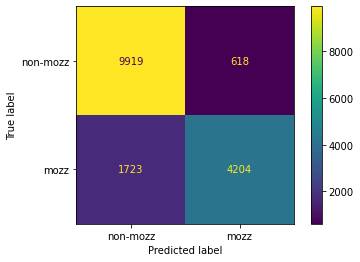

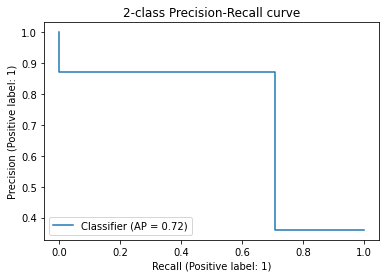

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

print('Accuracy score', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['non-mosquito', 'mosquito']))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['non-mozz','mozz'])

plt.show()

display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="Classifier")
_ = display.ax_.set_title("2-class Precision-Recall curve")

# **TASK 5** 

**Experiment with changing the contents of the test set, as determined in the code. What happens to the classification performance, and what does this tell us about the practice of creating datasets?**

---
If you do not have enough time to change and re-run code, what do you expect might happen, and what best practices should we apply to avoid "cherry picking" results with a particular dataset split?